# Notes

## TODO
- We need to redo our `user_quality_3bins` around meaningful cutoffs. I think anything above ~75% is good, between 65-75% is neutral, and below 65% is bad. Or could be above 80% is good, 65-80 is fine, and below 65 is bad.
- Update the way we do the NaN replacements
- Incorporate the interaction stats tables, e.g., ml-cdmx-interaction-stats.csv
- We need time per pano

## Notes to self
- Ugh, we do have a confound in that the validation information is also coming from bad users... hmm.
- Can we predict the correctness of an individual label? (e.g., based on whether it has a tag, a severity rating, etc.)


# Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn stuff
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold

# Utility functions

In [20]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

map_group_to_marker = {'Anonymous':'o', 'Registered':'v', 'Researcher':'s', 'Turker':'*'}
map_quality_to_marker = {'Bad':'^', 'Good':'p', 'Neutral':'X', 'Very Bad':'d', 'Very Good':'P'}

map_markers = { 'role' : map_group_to_marker,
                'quality' : map_quality_to_marker,
                'user_quality_3bins': map_quality_to_marker,
                'user_quality_5bins': map_quality_to_marker}

def display_overview(df):
    grouped_by_role = df.groupby('role')

    df_result = grouped_by_role[['n_audit_mission', 'meters_audited', 'n_label', 'n_validation_received']].sum()
    df_result['num_users'] = grouped_by_role['role'].count()

    # reorder cols: https://stackoverflow.com/a/13148611
    cols = df_result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_result = df_result[cols]
    df_result['Avg Accuracy'] = grouped_by_role['accuracy'].mean()
    df_result['Med Accuracy'] = grouped_by_role['accuracy'].median()
    df_result['SD Accuracy'] = grouped_by_role['accuracy'].std()

    if 'user_quality_3bins' in df.columns:
        grouped_by_role_and_quality = df_users.groupby(['user_quality_3bins', 'role'])
        df_result['Bad'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Bad']
        df_result['Neutral'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Neutral']
        df_result['Good'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Good']

    df_result.loc['Total'] = df_result.sum()
    
    int_cols = ['num_users', 'n_audit_mission', 'n_label', 'n_validation_received']
    
    if 'user_quality_3bins' in df.columns:
        int_cols.append(['Bad', 'Neutral', 'Good'])
    
    for col_name in int_cols:
        df_result[col_name] = df_result[col_name].fillna(0)
        df_result[col_name] = df_result[col_name].astype(int)
    
    df_result.at['Total', 'Avg Accuracy'] = df['accuracy'].mean()
    df_result.at['Total', 'Med Accuracy'] = df['accuracy'].median()
    df_result.at['Total', 'SD Accuracy'] = df['accuracy'].std()
    
    df_result.rename(columns={"n_validation_received": "Validations Received"}, inplace=True)
    
    #df_result2['meters_audited'] = df_result['meters_audited']
    display(df_result)

def plot_scatter(df, xcol_name, ycol_name, xlabel=None, ylabel=None, 
                 map_group_to_marker = None, xlim = None, ax = None,
                groupby='role'):
    groups = df.groupby(groupby)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    if map_group_to_marker is None:
        map_group_to_marker = map_markers[groupby]
    
    for name, group in groups:
        pairwise_corr = group[xcol_name].corr(group[ycol_name], method='pearson')
        #print(f"Corr of {xcol_name} to {ycol_name}: {cor}")
        ax.plot(group[xcol_name], group[ycol_name], marker=map_group_to_marker[name], 
                linestyle='', ms=10, alpha=0.65, label=f"{name} (r={pairwise_corr:0.2f})")
    ax.legend()
    
    if xlabel is None:
        xlabel = xcol_name
        
    if ylabel is None:
        ylabel = ycol_name
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(f"{xlabel} vs. {ylabel}")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #plt.show()
    return ax

def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues, figsize=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    if figsize is None:
        figsize = (12, 6)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


### FILE HANDLING ###
from os import listdir
import ntpath
import os

def get_csv_filenames(path_to_dir, suffix=".csv", include_path = True):
    """Gets all csv stat files in the directory"""
    filenames = listdir(path_to_dir)
    list_files = []
    for filename in filenames:
        filename_with_path = os.path.join(path_to_dir, filename)
        if filename.endswith(suffix) and 'interaction' not in filename.lower() and\
            filename.lower() != 'ml-codebook.csv':
            
            if include_path:
                list_files.append(filename_with_path)
            else:
                list_files.append(filename)
    return list_files
    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

def extract_city_name(filename):
    """Utility function to extract city name from filename. Filenames should have format: ml-cityname-stats.csv"""
    just_filename = path_leaf(filename)
    start_split_index = just_filename.index('-', 2) + 1
    end_split_index = just_filename.index('-', start_split_index)
    return just_filename[start_split_index:end_split_index]

def read_and_parse_data_file(csv_file):
    df_users_for_city = pd.read_csv(csv_file) 
    # df_users_for_city.rename(columns = {'validation_count':'validations_received_count'}, inplace = True) 
    
    # Calculate accuracy column
    df_users_for_city['accuracy'] = ((df_users_for_city['n_validation_received'] - df_users_for_city['n_received_disagree']) / 
                                    df_users_for_city['n_validation_received'])
    
    
    # Calculate curb ramp accuracy
    df_users_for_city['n_received_curb_ramp_validations'] = df_users_for_city['n_received_curb_ramp_agree'] + \
                          df_users_for_city['n_received_curb_ramp_disagree'] + \
                          df_users_for_city['n_received_curb_ramp_unsure']
    
    df_users_for_city['curb_ramp_accuracy'] = ((df_users_for_city['n_received_curb_ramp_validations'] - df_users_for_city['n_received_curb_ramp_disagree']) / 
                                    df_users_for_city['n_received_curb_ramp_validations'])
    
    # Calculate missing curb ramp accuracy
    df_users_for_city['n_received_missing_curb_ramp_validations'] = df_users_for_city['n_received_missing_curb_ramp_agree'] + \
                          df_users_for_city['n_received_missing_curb_ramp_disagree'] + \
                          df_users_for_city['n_received_missing_curb_ramp_unsure']
    
    df_users_for_city['missing_curb_ramp_accuracy'] = ((df_users_for_city['n_received_missing_curb_ramp_validations'] - df_users_for_city['n_received_missing_curb_ramp_disagree']) / 
                                    df_users_for_city['n_received_missing_curb_ramp_validations'])
    
    # Calculate obstacle accuracy
    df_users_for_city['n_received_obstacle_validations'] = df_users_for_city['n_received_obstacle_agree'] + \
                          df_users_for_city['n_received_obstacle_disagree'] + \
                          df_users_for_city['n_received_obstacle_unsure']
    
    df_users_for_city['obstacle_accuracy'] = ((df_users_for_city['n_received_obstacle_validations'] - df_users_for_city['n_received_obstacle_disagree']) / 
                                    df_users_for_city['n_received_obstacle_validations'])
    
    # Calculate surface problem accuracy
    df_users_for_city['n_received_surface_problem_validations'] = df_users_for_city['n_received_surface_problem_agree'] + \
                          df_users_for_city['n_received_surface_problem_disagree'] + \
                          df_users_for_city['n_received_surface_problem_unsure']
    
    df_users_for_city['surface_problem_accuracy'] = ((df_users_for_city['n_received_surface_problem_validations'] - df_users_for_city['n_received_surface_problem_disagree']) / 
                                    df_users_for_city['n_received_surface_problem_validations'])
        
    city_name = extract_city_name(csv_file).capitalize()
    df_users_for_city['city'] = city_name
    return df_users_for_city

def read_and_parse_data_files(csv_files, verbose = True):
    list_dfs = []
    for csv_file in csv_files:
        print(f"Reading in {csv_file}")
        df = read_and_parse_data_file(csv_file)
        if verbose:
            print(f"Read in {len(df)} users from {csv_file}")
            #display(df_users.groupby('role')['role', 'high_quality_manual'].count())
            display_overview(df)
        list_dfs.append(df)
    df_users = pd.concat(list_dfs)
    return df_users

# Read in data

In [21]:
%%time

csv_files = get_csv_filenames('data')
df_users = read_and_parse_data_files(csv_files)

# make a copy of the original DataFrame just in case we need it. We'll save
# the cleaned one in the original df_users DataFrame
df_users_original = df_users.copy()

Reading in data\ml-cdmx-stats.csv
Read in 150 users from data\ml-cdmx-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,21,37,4836.210391,621,522,0.861551,0.882353,0.122259
Registered,126,2641,385494.163256,27570,13461,0.868351,0.876276,0.075167
Researcher,3,81,21054.022976,1738,1421,0.929057,0.928205,0.015863
Total,150,2759,411384.396624,29929,15404,0.868613,0.879394,0.082646


Reading in data\ml-chicago-stats.csv
Read in 78 users from data\ml-chicago-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,1,1,112.748260,52,17,1.000000,1.000000,NaN
Registered,75,1032,144070.925463,7917,6429,0.751844,0.786667,0.156244
Researcher,2,10,1348.911047,182,143,0.955128,0.955128,0.009065
Total,78,1043,145532.584771,8151,6589,0.760238,0.790501,0.158946


Reading in data\ml-columbus-stats.csv
Read in 140 users from data\ml-columbus-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,40,113,19217.424444,1685,1011,0.860339,0.860390,0.114850
Registered,96,1518,305080.209324,21795,8862,0.869282,0.892425,0.096370
Researcher,4,184,36527.446366,5013,2052,0.926533,0.924264,0.029841
Total,140,1815,360825.080134,28493,11925,0.868363,0.894845,0.100916


Reading in data\ml-newberg-stats.csv
Read in 58 users from data\ml-newberg-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,13,57,15093.933399,1047,683,0.818633,0.859477,0.201268
Registered,13,246,69036.189037,4530,2403,0.882872,0.918297,0.172710
Researcher,6,181,53893.677056,5225,2308,0.870322,0.961457,0.226435
Turker,26,342,92145.815939,5739,3063,0.808078,0.920633,0.231934
Total,58,826,230169.615431,16541,8457,0.833647,0.913360,0.209626


Reading in data\ml-pittsburgh-stats.csv
Read in 42 users from data\ml-pittsburgh-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Registered,41,833,158343.910458,12761,1783,0.867372,0.896552,0.084154
Researcher,1,12,2609.785164,362,91,0.978022,0.978022,NaN
Total,42,845,160953.695621,13123,1874,0.870007,0.900331,0.084857


Reading in data\ml-seattle-stats.csv
Read in 740 users from data\ml-seattle-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,270,705,1.222028e+05,7666,6350,0.850270,0.886752,0.140959
Registered,307,8914,1.632472e+06,90922,59255,0.855229,0.887500,0.124751
Researcher,7,222,5.249096e+04,4562,2973,0.908366,0.906021,0.037842
Turker,156,3396,9.681896e+05,61724,31313,0.815962,0.865276,0.168306
Total,740,13237,2.775356e+06,164874,99891,0.845645,0.883484,0.141064


Reading in data\ml-spgg-stats.csv
Read in 304 users from data\ml-spgg-stats.csv


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,84,130,2.386701e+04,2418,1872,0.856362,0.882353,0.134097
Registered,217,7022,1.232049e+06,96967,25814,0.850928,0.863636,0.084197
Researcher,3,61,1.360187e+04,1985,1199,0.920179,0.915989,0.018156
Total,304,7213,1.269518e+06,101370,28885,0.853113,0.867990,0.100162


Wall time: 236 ms


In [22]:
print(f"We have {len(df_users)} users across {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city'])}")
display_overview(df_users)

We have 1512 users across 7 cities: ['Cdmx' 'Chicago' 'Columbus' 'Newberg' 'Pittsburgh' 'Seattle' 'Spgg']


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,429,1043,1.853302e+05,13489,10455,0.852344,0.882353,0.138249
Registered,875,22206,3.926547e+06,262462,118007,0.849712,0.872340,0.113027
Researcher,26,751,1.815267e+05,19067,10187,0.912408,0.929363,0.107588
Turker,182,3738,1.060335e+06,67463,34376,0.814836,0.869565,0.178033
Total,1512,27738,5.353739e+06,362481,173025,0.847339,0.875000,0.130392


## Data cleansing and processing

In [51]:
def display_users(def_sel_users):
    display(def_sel_users[["user_id", "role", "n_audit_mission", "n_validation_mission",
                           "meters_audited", "n_label", "accuracy"]])
    
# "n_label_with_tag", "n_validation_received", "n_validation_given"

In [55]:
# filtering thresholds
min_validations_rcvd_threshold = 10
min_num_labels_threshold = 15
min_missions_completed = 1

# Grab original dataframe
df_users = df_users_original.copy()

# TODO: something is fishy with these filtering. Needs to be investigated. Maybe we're using the .index wrong?
# TODO: to help with this, would be good to have a display_overview like function but for users

# Remove users who have audited < 0 meters
if len(df_users[df_users.meters_audited < 0]) > 0:
    print(f"The following indices have meters_audited < 0: {df_users[df_users.meters_audited < 0].index}")
    df_users.drop(df_users[df_users.meters_audited < 0].index, inplace=True)
    print("len(df_users) =",len(df_users))

# Remove users who have not finished a mission
query_result = df_users[df_users.n_audit_mission < min_missions_completed]
# print(query_result)
display_users(query_result)
num_users_who_never_finished_a_mission = len(query_result)
print("{}/{} users ({:0.1f}%) never completed {} missions. Removing them from analysis.".format(
    num_users_who_never_finished_a_mission, len(df_users), 
    num_users_who_never_finished_a_mission / len(df_users) * 100,
    min_missions_completed))
df_users.drop(query_result.index, inplace=True)
print("len(df_users) =",len(df_users))

# Remove users who have not provided a minimum number of labels
query_result = df_users[df_users.n_label < min_num_labels_threshold]
num_users_without_min_labels = len(query_result)
display_users(query_result)
print("{}/{} users ({:0.1f}%) have not provided the min num of labels of {}. Removing them from analysis.".format(
    num_users_without_min_labels, len(df_users), 
    num_users_without_min_labels / len(df_users) * 100, min_num_labels_threshold))
df_users.drop(query_result.index, inplace=True)
print("len(query_result) =",len(query_result))
print("len(df_users) =",len(df_users))

# Remove users who have not received the minimum number of validations
query_result = df_users[df_users.n_validation_received < min_validations_rcvd_threshold]
num_users_without_min_validations_rcvd = len(query_result)
print("{}/{} users ({:0.1f}%) have not received the min num of validations of {}. Removing them from analysis.".format(
    num_users_without_min_validations_rcvd, len(df_users), 
    num_users_without_min_validations_rcvd / len(df_users) * 100, min_validations_rcvd_threshold))
df_users.drop(query_result.index, inplace=True)
print("len(df_users)=",len(df_users))

# add in labels per meter
df_users['labels_per_meter'] = df_users['n_label'] / df_users['meters_audited']
df_users['curb_ramp_labels_per_meter'] = df_users['n_curb_ramp'] / df_users['meters_audited']
df_users['missing_curb_ramp_labels_per_meter'] = df_users['n_missing_curb_ramp'] / df_users['meters_audited']
df_users['obstacle_labels_per_meter'] = df_users['n_obstacle'] / df_users['meters_audited']
df_users['surface_problem_labels_per_meter'] = df_users['n_surface_problem'] / df_users['meters_audited']
df_users['no_sidewalk_labels_per_meter'] = df_users['n_no_sidewalk'] / df_users['meters_audited']

# Replace np.nan, np.inf, -np.inf
df_users['labels_per_meter'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# convert high quality column to boolean
df_users['high_quality_manual'].replace(['f'], False, inplace=True)
df_users['high_quality_manual'].replace(['t'], True, inplace=True)
df_users['high_quality_manual'] = df_users['high_quality_manual'].astype('bool')

# add in percentage of labels that have severity
df_users['labels_with_severity_fraction'] = df_users['n_label_with_severity'] / df_users['n_label']
df_users['curb_ramps_with_severity_fraction'] = df_users['n_curb_ramp_with_severity'] / df_users['n_curb_ramp']
df_users['missing_curb_ramps_with_severity_fraction'] = df_users['n_missing_curb_ramp_with_severity'] / df_users['n_missing_curb_ramp']
df_users['obstacles_with_severity_fraction'] = df_users['n_obstacle_with_severity'] / df_users['n_obstacle']
df_users['surface_problems_with_severity_fraction'] = df_users['n_surface_problem_with_severity'] / df_users['n_surface_problem']
df_users['no_sidewalks_with_severity_fraction'] = df_users['n_no_sidewalk_with_severity'] / df_users['n_no_sidewalk']

# add in percentage of labels that have tags
df_users['labels_with_tags_fraction'] = df_users['n_label_with_tag'] / df_users['n_label']
df_users['curb_ramps_with_tags_fraction'] = df_users['n_curb_ramp_with_tag'] / df_users['n_curb_ramp']
df_users['missing_curb_ramps_with_tags_fraction'] = df_users['n_missing_curb_ramp_with_tag'] / df_users['n_missing_curb_ramp']
df_users['obstacles_with_tags_fraction'] = df_users['n_obstacle_with_tag'] / df_users['n_obstacle']
df_users['surface_problems_with_tags_fraction'] = df_users['n_surface_problem_with_tag'] / df_users['n_surface_problem']
df_users['no_sidewalks_with_tags_fraction'] = df_users['n_no_sidewalk_with_tag'] / df_users['n_no_sidewalk']

# add in quality groupings
quality_bin_labels_5 = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']
df_users['user_quality_5bins'] = pd.qcut(df_users['accuracy'], 5, labels=quality_bin_labels_5)

quality_bin_labels_3 = ['Bad', 'Neutral', 'Good']
df_users['user_quality_3bins'] = pd.qcut(df_users['accuracy'], 3, labels=quality_bin_labels_3)

# print out total number filtered out
total_filtered = len(df_users_original) - len(df_users)
total_filtered_percentage = total_filtered / len(df_users_original) * 100
print(f"We filtered out {total_filtered}/{len(df_users_original)} users ({total_filtered_percentage:.2f}%)")
print(f"{len(df_users)} total users remain across the {len(pd.unique(df_users['city']))} cities")

# Replace NaN with the mean of the respective columns
cols_with_nan = df_users_original.columns[df_users_original.isna().any()].tolist()
if len(cols_with_nan) > 0:
    print("-------")
    print(f"The following {len(cols_with_nan)} column(s) have NaN data, which will be " +
          f"replaced by the mean of the respective columns:\n{df_users_original.isna().sum()[cols_with_nan]}")
    df_users.fillna(df_users.mean(), inplace=True)

,user_id,role,n_audit_mission,n_validation_mission,meters_audited,n_label,accuracy
20,1f3786df-b424-4092-932f-1e27161a0215,Registered,0,0,135.680588,39,0.843750
48,5593e320-2329-4c53-8d8e-104687c14486,Registered,0,0,141.713455,15,0.846154
51,58f998b4-71ec-4a53-8cf5-a77b4273afc3,Anonymous,0,0,79.562562,15,1.000000
72,7adf05e6-3b05-484d-ab97-515710fdd649,Anonymous,0,0,17.668007,12,0.909091
132,e3ad768b-5867-4c9c-b733-d05ac77add70,Anonymous,0,0,33.785172,24,0.923077
...,...,...,...,...,...,...,...
242,c419e83c-ae76-4ce5-8e46-8460405ae704,Anonymous,0,3,61.615810,16,1.000000
259,dcd750b1-252b-4fa0-bd00-9974ba86423e,Registered,0,0,26.537218,14,1.000000
278,ea32a23c-9629-41b8-a7bc-e577dd53ca4b,Anonymous,0,0,115.727768,31,0.965517
287,ee629c2f-35f7-4d38-8a33-3a0e9193db3c,Anonymous,0,0,95.380470,22,0.850000


77/1512 users (5.1%) never completed 1 missions. Removing them from analysis.
len(df_users) = 1313


,user_id,role,n_audit_mission,n_validation_mission,meters_audited,n_label,accuracy
1,0232f5a5-79c5-491e-bd54-9b4577fbfe4a,Anonymous,1,0,152.399994,12,0.818182
13,0c2dc684-1fc4-488c-921f-cffb09a37550,Registered,1,0,152.399994,12,0.833333
24,257432ee-7dfa-4c0c-94b1-f7fac7951db3,Anonymous,1,2,76.199997,14,0.800000
33,35c56f59-5242-446e-a8d9-f59ed7f4808d,Anonymous,1,0,152.399994,12,0.916667
57,614bf2bc-d241-4896-bec3-65b12a878870,Registered,1,4,76.199997,14,0.750000
...,...,...,...,...,...,...,...
246,cbbd5753-9512-48da-a947-30f3371a0268,Anonymous,2,0,304.799988,11,1.000000
248,cf2bd96f-d186-4682-9fc6-06ccb4df0a24,Anonymous,1,0,152.399994,11,1.000000
270,e5209185-bd10-42f3-b8f0-ee579bebe5e3,Anonymous,1,3,152.399994,13,1.000000
271,e5d8b30d-aeed-4259-91be-9c9c575ec247,Anonymous,1,2,152.399994,11,1.000000


142/1313 users (10.8%) have not provided the min num of labels of 15. Removing them from analysis.
len(query_result) = 142
len(df_users) = 965
0/965 users (0.0%) have not received the min num of validations of 10. Removing them from analysis.
len(df_users)= 965
We filtered out 547/1512 users (36.18%)
965 total users remain across the 7 cities
-------
The following 31 column(s) have NaN data, which will be replaced by the mean of the respective columns:
high_quality_manual                1413
label_severity_min                    1
label_severity_max                    1
label_severity_mean                   1
label_severity_sd                     1
curb_ramp_severity_min               95
curb_ramp_severity_max               95
curb_ramp_severity_mean              95
curb_ramp_severity_sd               146
missing_curb_ramp_severity_min      202
missing_curb_ramp_severity_max      202
missing_curb_ramp_severity_mean     202
missing_curb_ramp_severity_sd       311
obstacle_severity_min  

In [42]:
#display(df_users.groupby('role')['audit_mission_count', 'meters_audited', 'n_label'].sum())
print(f"Before data cleansing: {len(pd.unique(df_users_original['city']))} cities: {pd.unique(df_users_original['city']).tolist()}")
display_overview(df_users_original)

print(f"After data cleansing: {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city']).tolist()}")
display_overview(df_users)

Before data cleansing: 7 cities: ['Cdmx', 'Chicago', 'Columbus', 'Newberg', 'Pittsburgh', 'Seattle', 'Spgg']


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,429,1043,1.853302e+05,13489,10455,0.852344,0.882353,0.138249
Registered,875,22206,3.926547e+06,262462,118007,0.849712,0.872340,0.113027
Researcher,26,751,1.815267e+05,19067,10187,0.912408,0.929363,0.107588
Turker,182,3738,1.060335e+06,67463,34376,0.814836,0.869565,0.178033
Total,1512,27738,5.353739e+06,362481,173025,0.847339,0.875000,0.130392


After data cleansing: 4 cities: ['Cdmx', 'Columbus', 'Seattle', 'Spgg']


,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy,Bad,Neutral,Good
role,,,,,,,,,,,
Anonymous,29,222,4.942554e+04,2477,1808,0.836151,0.871795,0.151355,7,12,10
Registered,162,6288,1.117797e+06,86167,46204,0.853979,0.871083,0.091991,57,49,56
Researcher,7,261,6.301138e+04,6096,3971,0.927328,0.927835,0.030497,0,3,4
Turker,38,2585,7.493351e+05,48169,23198,0.824788,0.876313,0.125641,15,14,9
Total,236,9356,1.979569e+06,142909,75181,0.849264,0.872837,0.106542,79,78,79


In [17]:
df_users.sample(5)

,user_id,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,n_received_curb_ramp_disagree,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
603,d2b04e27-13ce-4aff-a06a-7c7147c96696,Registered,814,425,227,29,133,67,59,6,...,0.930070,0.942308,0.469900,0.624277,0.044601,0.731250,0.881119,0.721154,Very Bad,Bad
422,91376904-0b1e-4a89-a83b-fa5d9c52f20f,Turker,46,26,11,7,2,15,11,4,...,1.000000,0.968254,0.581818,0.562500,1.000000,0.937500,0.923077,0.412698,Very Bad,Bad
429,95b778e8-26c2-424d-b879-07c558bb9b20,Turker,301,258,21,5,17,233,211,17,...,0.869565,1.000000,0.977273,0.975089,1.000000,0.923077,1.000000,1.000000,Good,Good
114,5aa60411-8a71-4f53-8e94-88ae6c963d2d,Anonymous,25,8,10,2,5,3,3,0,...,0.889684,1.000000,0.703704,0.333333,0.916667,0.545455,0.881965,1.000000,Very Bad,Bad
292,68a7c347-7bba-4059-acb8-a7e7913d75b9,Turker,12,9,1,0,2,0,0,0,...,1.000000,0.884013,0.916667,0.474900,1.000000,0.888889,1.000000,0.769309,Good,Good


# Exploratory analysis

In [18]:
df_users.groupby('role').describe()

n_validation_received                                             \
                           count        mean         std   min   25%    50%   
role                                                                          
Anonymous                  359.0   25.136490   25.302434  10.0  13.0   17.0   
Registered                 779.0  140.118100  497.330053  10.0  26.0   47.0   
Researcher                  23.0  370.652174  394.724485  12.0  34.0  220.0   
Turker                     152.0  221.322368  604.872299  10.0  17.0   29.0   

                           n_received_agree              ...  \
               75%     max            count        mean  ...   
role                                                     ...   
Anonymous    28.00   306.0            359.0   17.919220  ...   
Registered   98.50  6986.0            779.0  106.865212  ...   
Researcher  614.00  1389.0             23.0  300.130435  ...   
Turker       59.75  4135.0            152.0  164.618421  ...   

           surface_problems_with_tags_fraction       \
                                           75%  max   
role                                                  
Anonymous                             1.000000  1.0   
Registered                            1.000000  1.0   
Researcher                            0.989865  1.0   
Turker                                1.000000  1.0   

           no_sidewalks_with_tags_fraction                                     \
                                     count      mean       std  min       25%   
role                                                                            
Anonymous                            359.0  0.775150  0.225559  0.0  0.769309   
Registered                           779.0  0.788082  0.269979  0.0  0.769309   
Researcher                            23.0  0.563056  0.406444  0.0  0.104226   
Turker                               152.0  0.690510  0.322377  0.0  0.746822   

                                     
                 50%       75%  max  
role                                 
Anonymous   0.769309  1.000000  1.0  
Registered  0.821429  1.000000  1.0  
Researcher  0.736842  0.941769  1.0  
Turker      0.769309  0.946267  1.0  

[4 rows x 904 columns]

In [19]:
display(df_users.sort_values(by=['labels_per_meter'], ascending=False).head(5))

,user_id,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,n_received_curb_ramp_disagree,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
31,1d27adc6-01e9-4d7d-8411-3e0eee2ef634,Anonymous,13,13,0,0,0,0,0,0,...,1.000000,0.884013,1.000000,0.474900,1.0,1.0,1.000000,0.769309,Very Good,Good
234,bf8482b3-ffd4-4b17-9b57-467cbf21791a,Anonymous,35,24,1,3,7,13,10,0,...,1.000000,0.884013,1.000000,1.000000,1.0,1.0,1.000000,0.769309,Very Good,Good
110,2283173a-8e7f-4bff-bdc3-c95c277e8f14,Anonymous,26,8,16,0,2,13,6,7,...,1.000000,0.884013,0.710526,0.583333,1.0,0.8,1.000000,0.769309,Very Bad,Bad
67,13e7634d-5c62-4f39-ba2e-28c44ab58dcc,Anonymous,20,14,4,1,1,12,11,1,...,0.714286,1.000000,0.274194,0.046512,1.0,1.0,0.714286,1.000000,Bad,Bad
71,3ab3f2fb-f47c-4112-a041-83d1b6115340,Registered,71,59,2,5,5,7,7,0,...,0.904762,1.000000,0.971154,1.000000,1.0,1.0,1.000000,1.000000,Very Good,Good


In [20]:
display(df_users.sort_values(by=['accuracy', 'labels_per_meter'], ascending=False).head(5))

,user_id,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,n_received_curb_ramp_disagree,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
31,1d27adc6-01e9-4d7d-8411-3e0eee2ef634,Anonymous,13,13,0,0,0,0,0,0,...,1.000000,0.884013,1.000000,0.474900,1.000000,1.00000,1.000000,0.769309,Very Good,Good
55,bb3f9414-bb24-4037-93d3-ebeab1c886de,Anonymous,17,12,0,0,5,2,2,0,...,0.923077,0.000000,0.326923,1.000000,1.000000,0.80742,0.846154,0.000000,Very Good,Good
421,91187625-0ac4-4b2e-b385-0ad9f4a5ee59,Anonymous,13,13,0,0,0,5,5,0,...,0.889684,0.884013,0.769231,0.600000,1.000000,0.00000,0.881965,0.769309,Very Good,Good
163,36a089e7-448a-42cc-8cb3-af3042537571,Anonymous,10,9,0,1,0,10,9,0,...,0.889684,0.884013,0.000000,0.000000,0.708244,0.80742,0.881965,0.769309,Very Good,Good
193,40b9c6eb-a498-4631-bc98-69cc4b7eb0d0,Registered,17,17,0,0,0,17,17,0,...,0.889684,0.884013,0.029412,0.029412,0.708244,0.80742,0.881965,0.769309,Very Good,Good


## Scatter plots of features

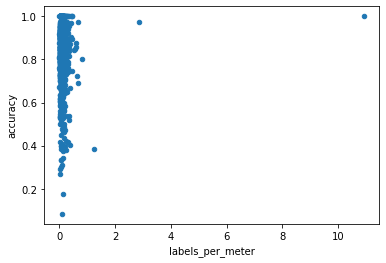

In [21]:
# We can use Pandas to create a scatter plot directly but hard to color by user group
ax = df_users.plot.scatter(x='labels_per_meter', y='accuracy')

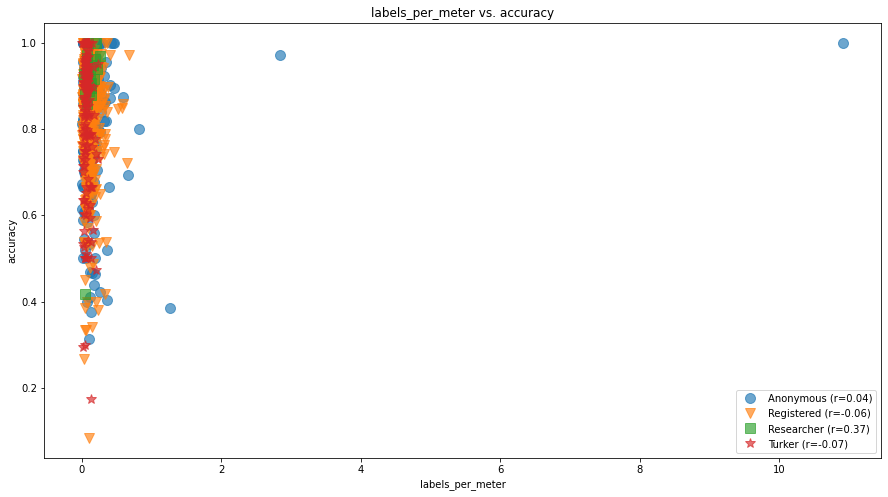

In [22]:
# So I made my own scatter plot. Let's look at the relationship between labels_per_meter and accuracy
plot_scatter(df_users, 'labels_per_meter', 'accuracy');

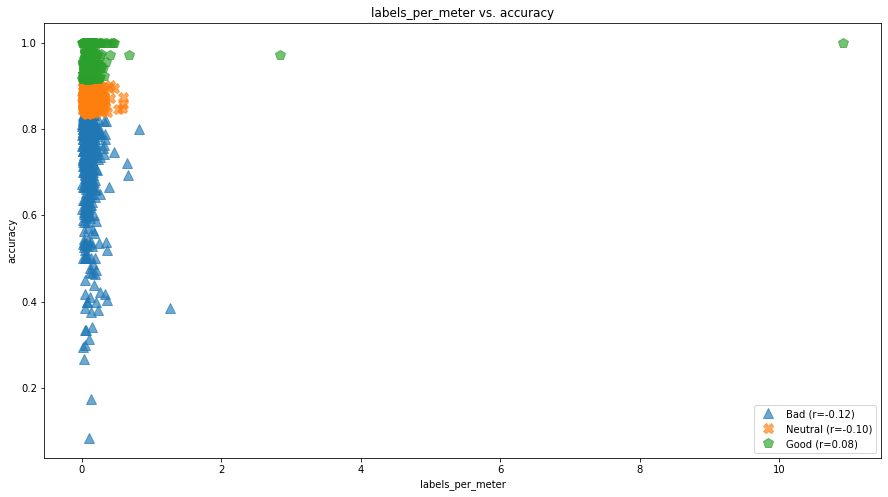

In [23]:
plot_scatter(df_users, 'labels_per_meter', 'accuracy', groupby='user_quality_3bins');

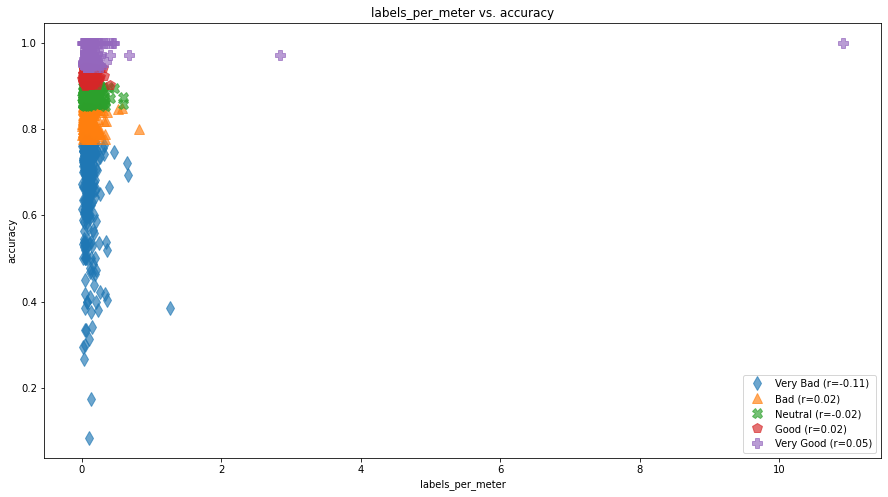

In [37]:
plot_scatter(df_users, 'labels_per_meter', 'accuracy', groupby='user_quality_5bins');

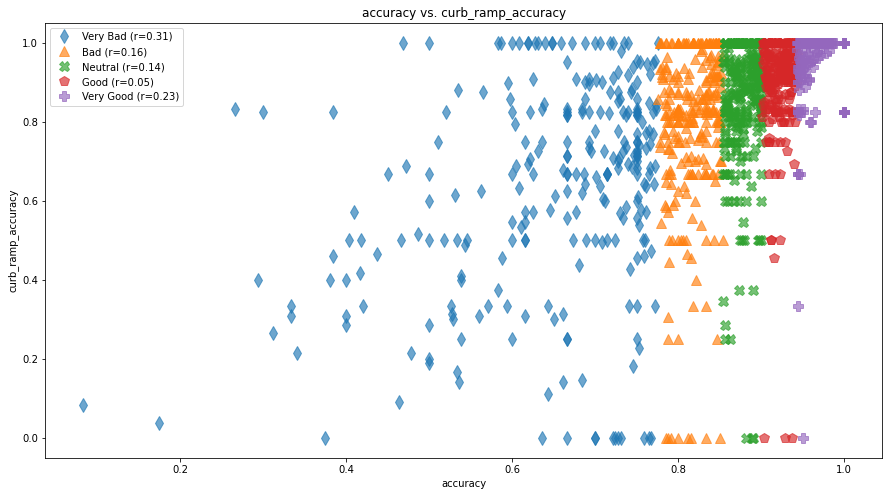

In [38]:
plot_scatter(df_users, 'accuracy', 'curb_ramp_accuracy', groupby='user_quality_5bins');

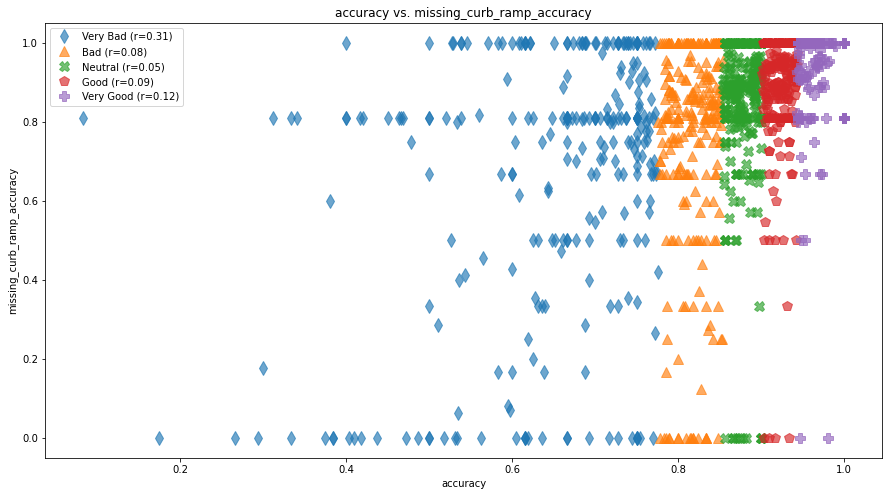

In [39]:
plot_scatter(df_users, 'accuracy', 'missing_curb_ramp_accuracy', groupby='user_quality_5bins');

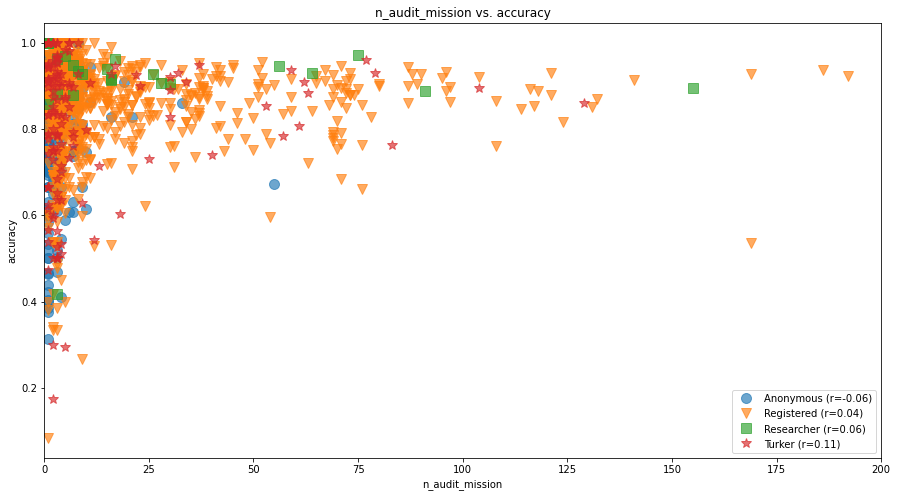

In [25]:
plot_scatter(df_users, 'n_audit_mission', 'accuracy', xlim=(0, 200));

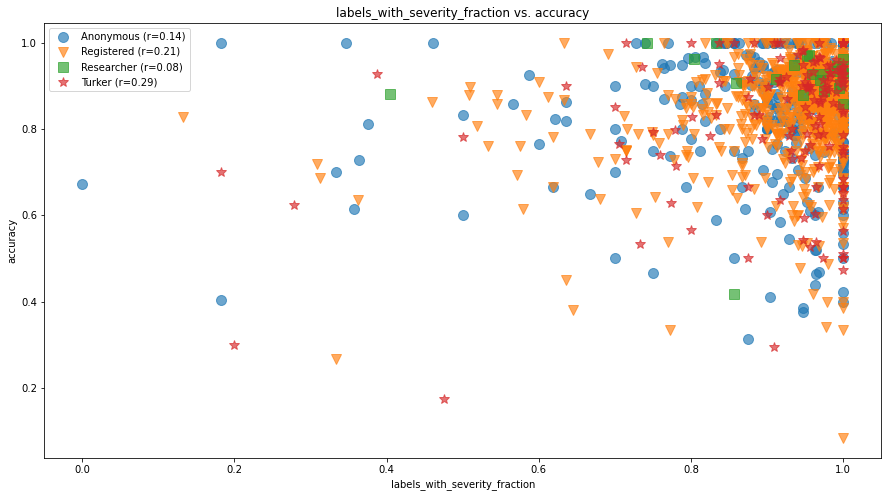

In [26]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy');

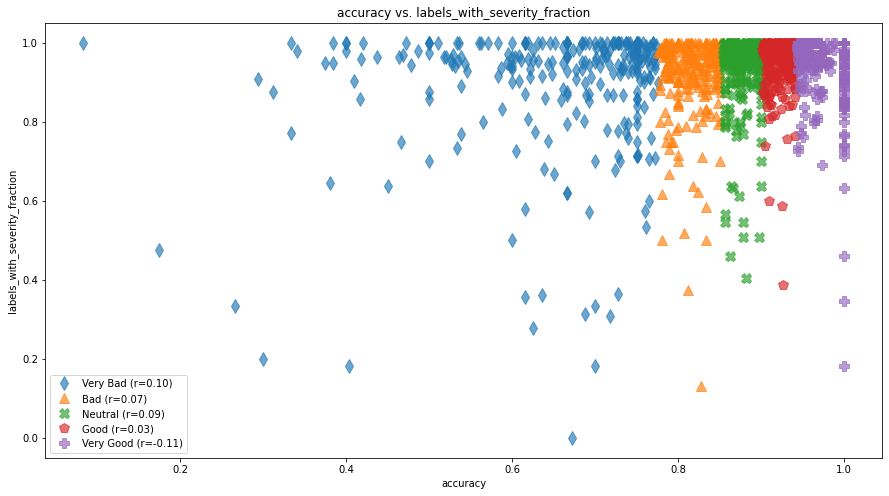

In [40]:
plot_scatter(df_users, 'accuracy', 'labels_with_severity_fraction', groupby='user_quality_5bins');

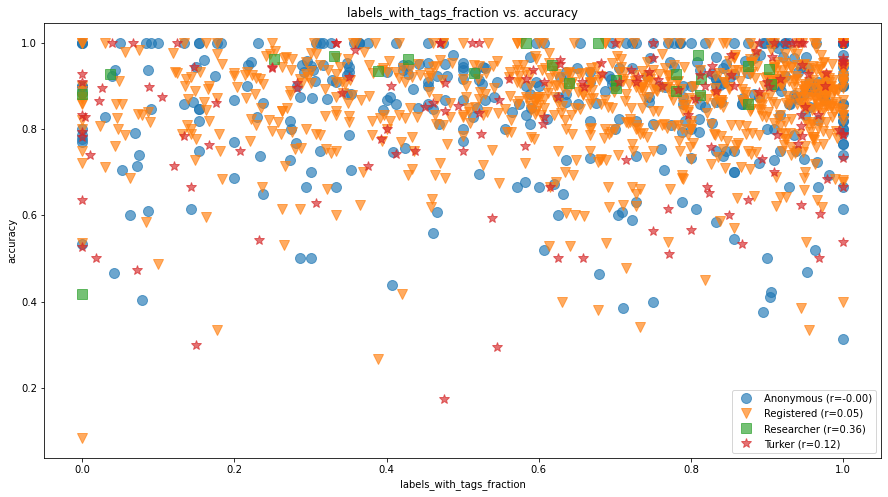

In [27]:
plot_scatter(df_users, 'labels_with_tags_fraction', 'accuracy');

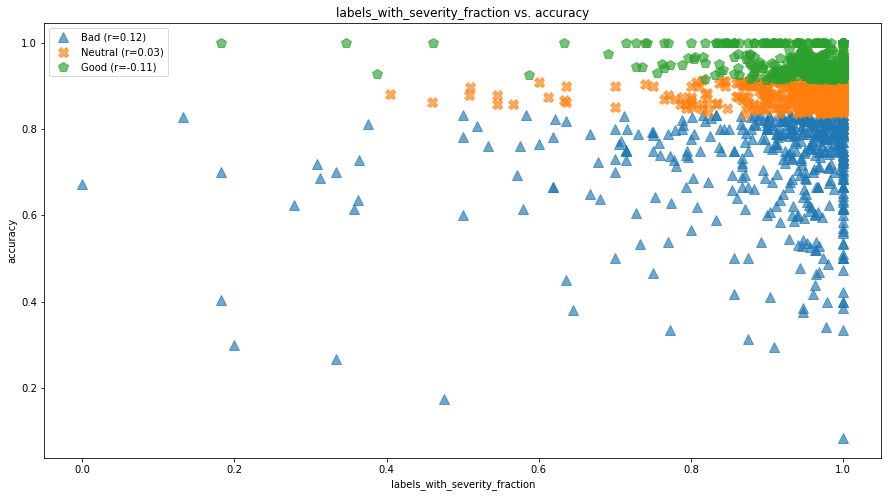

In [28]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', groupby='user_quality_3bins');

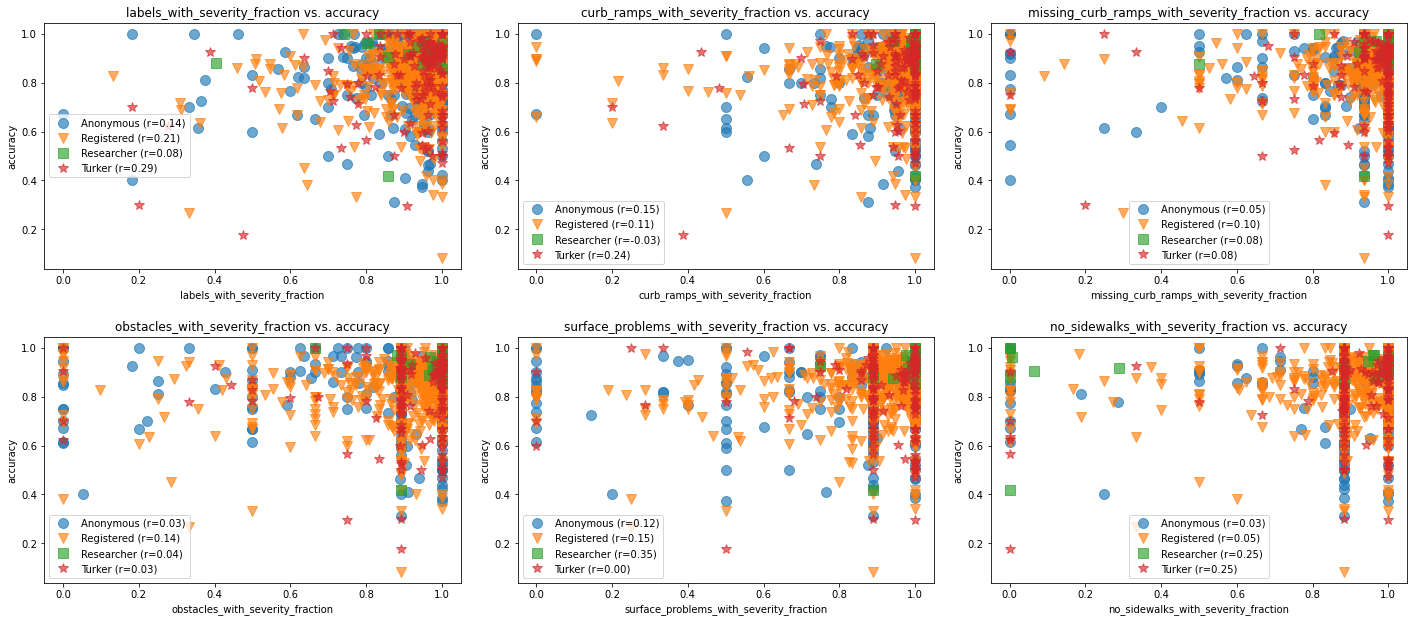

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

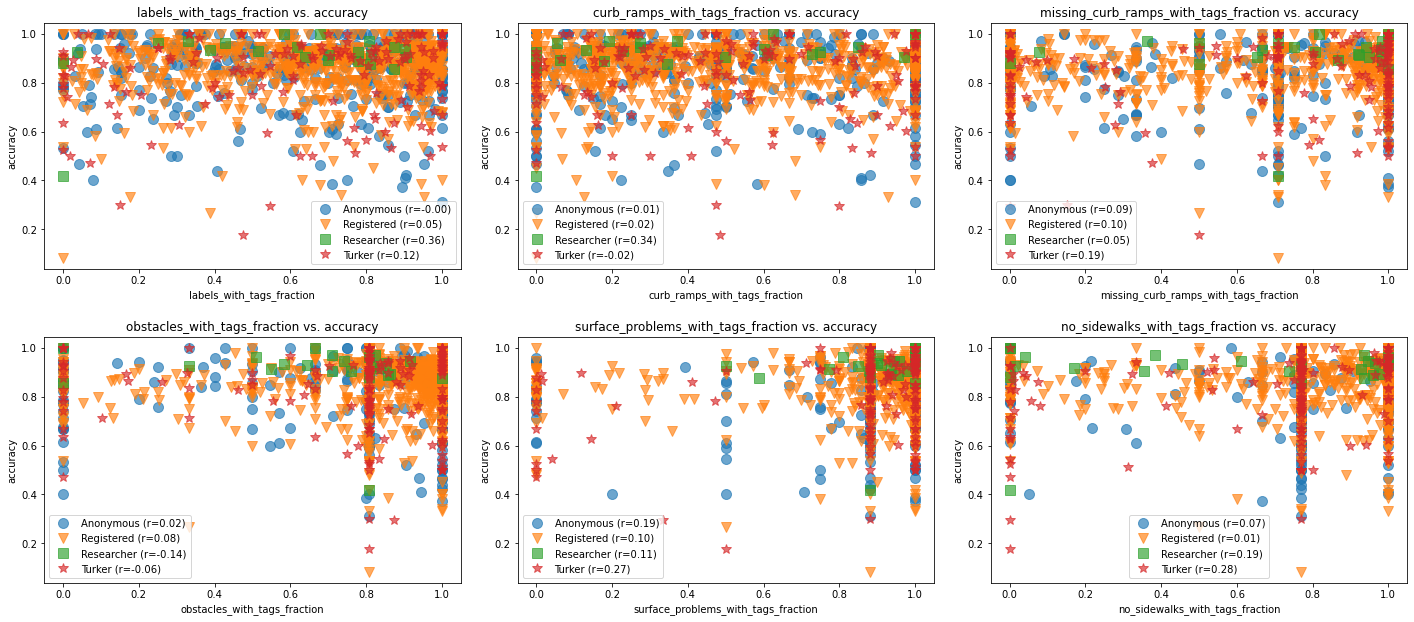

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_tags_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_tags_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_tags_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_tags_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_tags_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_tags_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

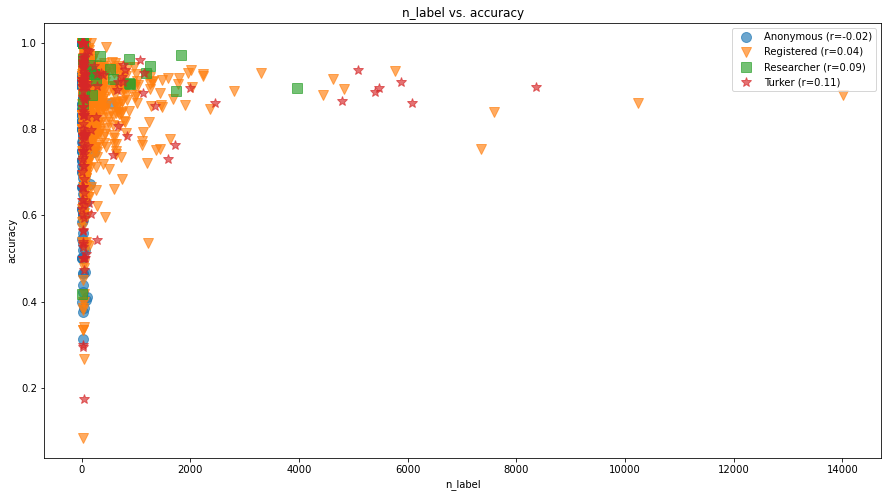

In [34]:
plot_scatter(df_users, 'n_label', 'accuracy');

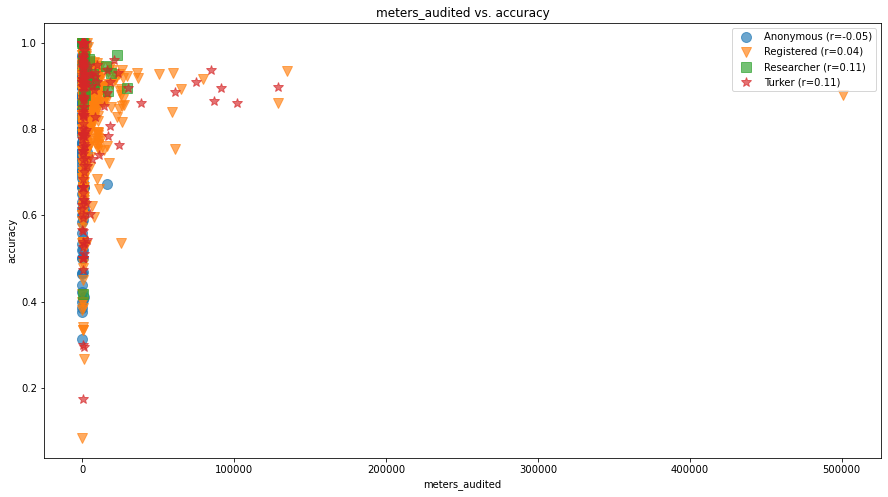

In [35]:
plot_scatter(df_users, 'meters_audited', 'accuracy');

# Accuracy as a function of role

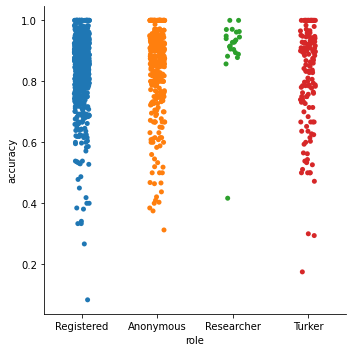

In [36]:
# from: https://seaborn.pydata.org/tutorial/categorical.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
sns.catplot(x="role", y="accuracy", jitter=True, data=df_users);

,num_users,n_audit_mission,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy,Bad,Neutral,Good
role,,,,,,,,,,,
Anonymous,359,980,1.695376e+05,11695,9024,0.849973,0.882353,0.138381,124,99,136
Registered,779,19598,3.484872e+06,236006,109152,0.850010,0.872340,0.113026,267,280,232
Researcher,23,637,1.490130e+05,15387,8525,0.907798,0.928205,0.113418,1,7,15
Turker,152,3698,1.048308e+06,66438,33641,0.825836,0.884828,0.162822,63,35,54
Total,1313,24913,4.851731e+06,329526,160342,0.848214,0.875000,0.127242,455,421,437


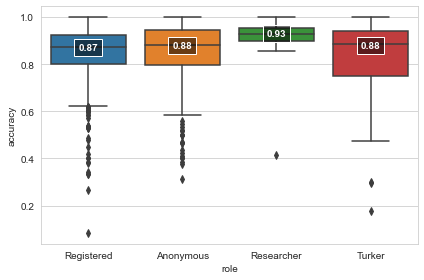

In [37]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot
sns.set_style("whitegrid")
# sns.catplot(x="role", y="accuracy", kind="box", data=df_users, height=6);
box_plot = sns.boxplot(x="role", y="accuracy", data=df_users)

# add in values
# from: https://stackoverflow.com/a/56879116
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0], 2) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
        size=10, color='w', bbox=dict(facecolor='#00000088'))

box_plot.figure.tight_layout()
display_overview(df_users)

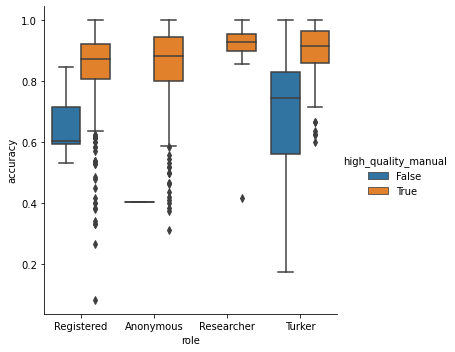

In [33]:
sns.catplot(x="role", y="accuracy", kind="box", hue='high_quality_manual', data=df_users);

## Histograms

### Histogram of accuracy

C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


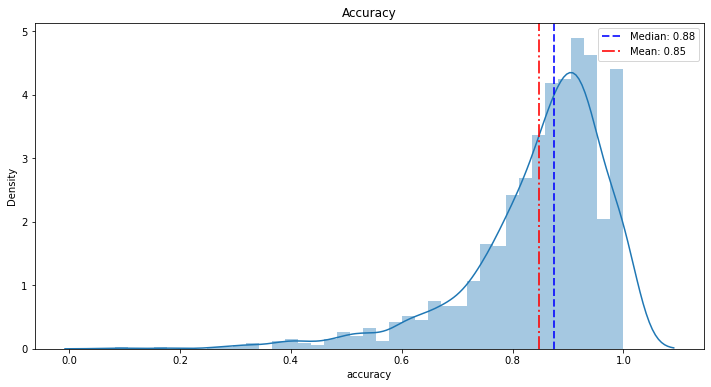

In [34]:
import seaborn as sns, numpy as np

plt.figure(figsize=(12, 6))
ax = sns.distplot(df_users['accuracy'])
plt.axvline(np.median(df_users['accuracy']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['accuracy']):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users['accuracy']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['accuracy']):0.2f}", linewidth=2, alpha=0.8)
ax.set_title('Accuracy')
plt.legend();

C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


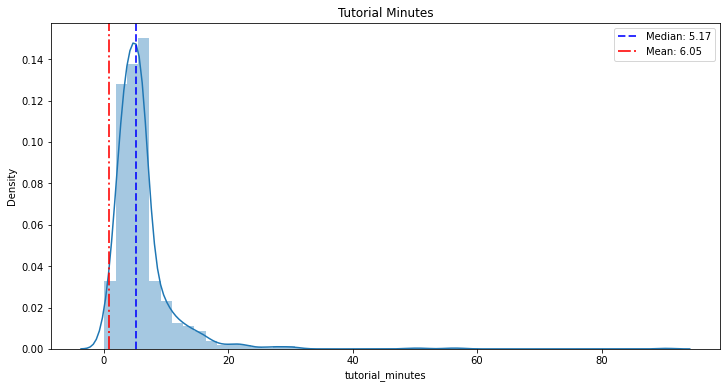

In [35]:
plt.figure(figsize=(12, 6))
ax = sns.distplot(df_users['tutorial_minutes'])
plt.axvline(np.median(df_users['tutorial_minutes']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['tutorial_minutes']):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users['accuracy']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['tutorial_minutes']):0.2f}", linewidth=2, alpha=0.8)
ax.set_title('Tutorial Minutes')
plt.legend();

C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


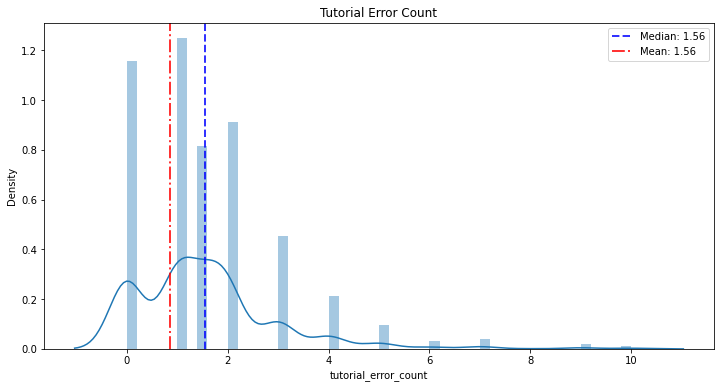

In [36]:
plt.figure(figsize=(12, 6))
ax = sns.distplot(df_users['tutorial_error_count'])
plt.axvline(np.median(df_users['tutorial_error_count']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['tutorial_error_count']):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users['accuracy']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['tutorial_error_count']):0.2f}", linewidth=2, alpha=0.8)
ax.set_title('Tutorial Error Count')
plt.legend();

C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

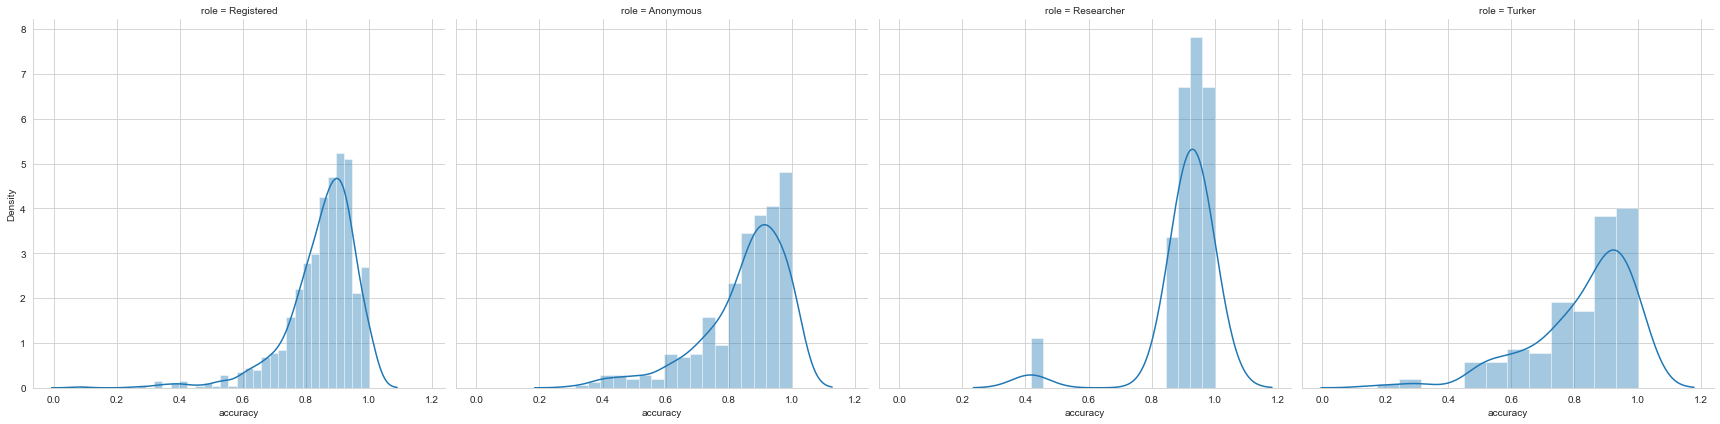

In [40]:
# https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/
g = sns.FacetGrid(df_users, row=None, col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel 

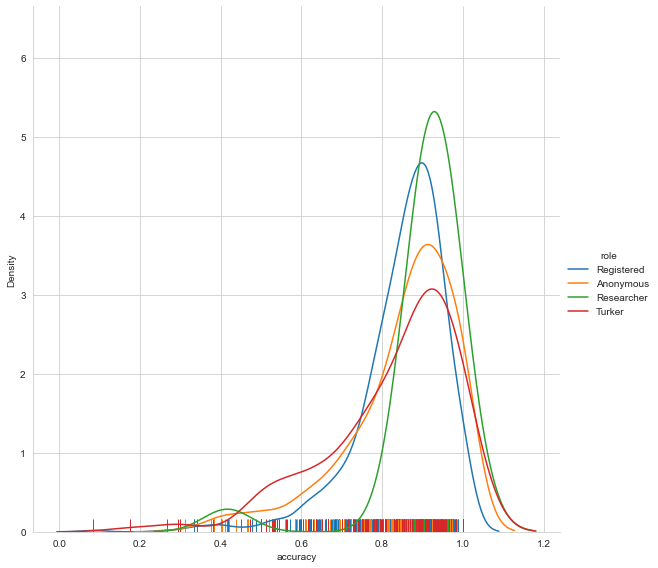

In [41]:
# fig, ax = plt.subplots(figsize=(10, 8))
g = sns.FacetGrid(df_users, hue="role", height=8)
g = g.map(sns.distplot, "accuracy",  hist=False, rug=True);
g.add_legend()

### Histogram of labels/meter

C:\Users\jonf\anaconda3\envs\sidewalk-quality-analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


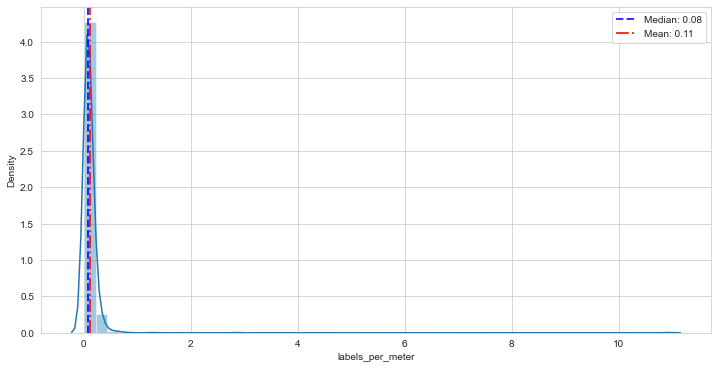

In [42]:
plt.figure(figsize=(12, 6))
col = 'labels_per_meter'
ax = sns.distplot(df_users[col])
plt.axvline(np.median(df_users[col]), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users[col]):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users[col]), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users[col]):0.2f}", linewidth=2, alpha=0.8)
plt.legend();

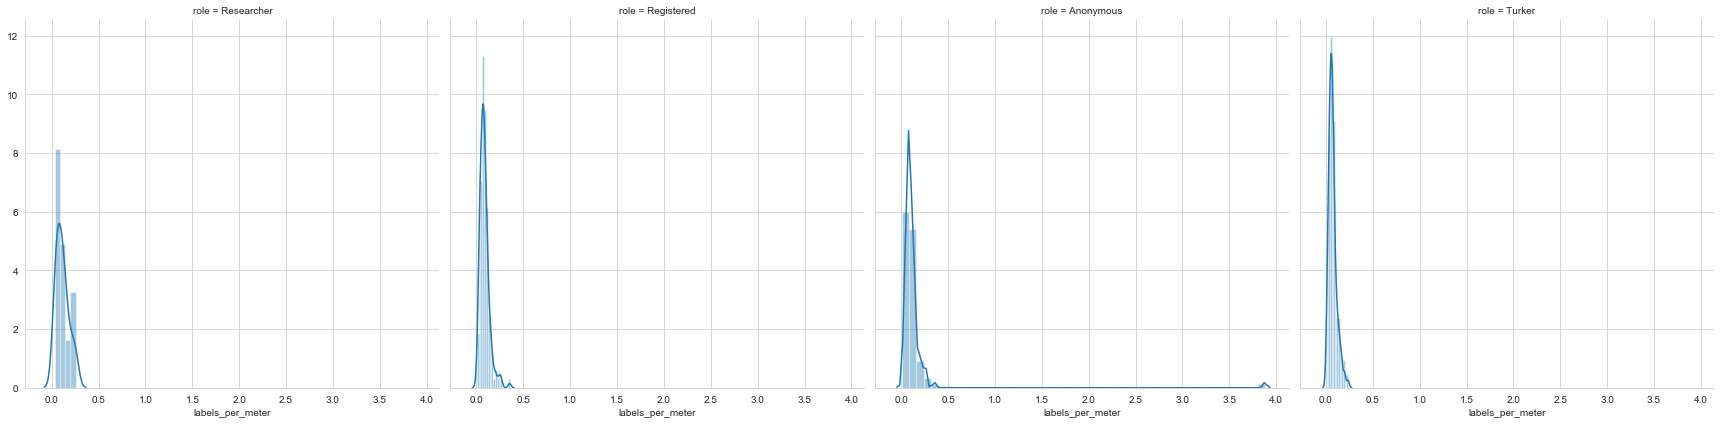

In [120]:
g = sns.FacetGrid(df_users, col='role', height = 6)
g.map(sns.distplot, "labels_per_meter")

## Joint ploints

ValueError: cannot reindex from a duplicate axis

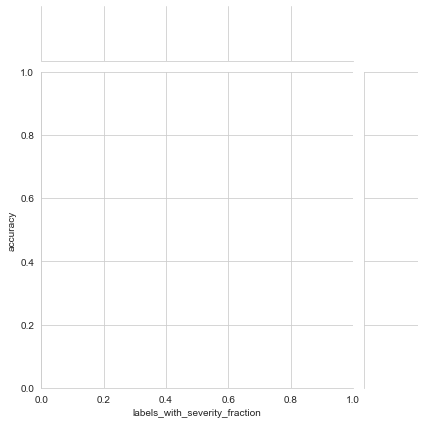

In [43]:
j = sns.jointplot(data=df_users, x='labels_with_severity_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

ValueError: cannot reindex from a duplicate axis

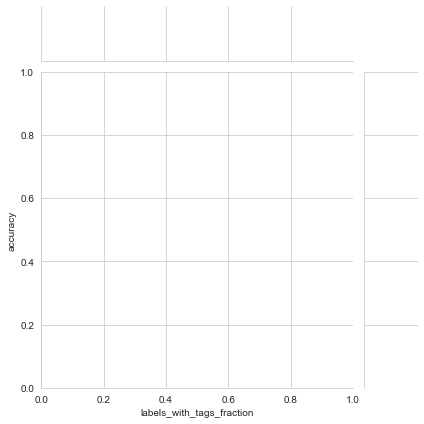

In [44]:
j = sns.jointplot(data=df_users, x='labels_with_tags_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

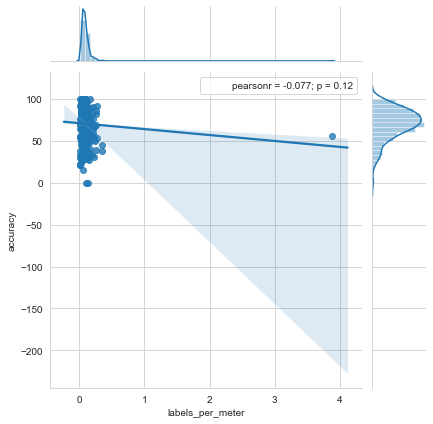

In [124]:
j = sns.jointplot(data=df_users, x='labels_per_meter', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr)
plt.show()

# Regression predictions

In [11]:
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
# plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
# plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
# plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
# plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])

input_feature_cols = []

# Add in labels/meter input features
input_feature_cols.extend(['labels_per_meter'])
input_feature_cols.extend(['curb_ramp_labels_per_meter', 'missing_curb_ramp_labels_per_meter', 
                           'obstacle_labels_per_meter', 'surface_problem_labels_per_meter', 'no_sidewalk_labels_per_meter'])

# Add in severity input features
input_feature_cols.extend(['labels_with_severity_fraction'])
input_feature_cols.extend(['missing_curb_ramps_with_severity_fraction',
              'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
              'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction'])

# Add in tag input features
input_feature_cols.extend(['labels_with_tags_fraction'])
input_feature_cols.extend(['missing_curb_ramps_with_tags_fraction',
              'obstacles_with_tags_fraction', 'surface_problems_with_tags_fraction', 
              'curb_ramps_with_tags_fraction', 'no_sidewalks_with_tags_fraction'])

X = df_users[input_feature_cols]

#X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction']]
y = df_users['accuracy'].values

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
display(coeff_df)

y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(df.sample(10))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

,Coefficient
labels_per_meter,0.825866
curb_ramp_labels_per_meter,-1.354855
missing_curb_ramp_labels_per_meter,-0.357442
obstacle_labels_per_meter,-1.045117
surface_problem_labels_per_meter,-1.006584
no_sidewalk_labels_per_meter,-0.873477
labels_with_severity_fraction,0.226582
missing_curb_ramps_with_severity_fraction,-0.046084
obstacles_with_severity_fraction,-0.022389
surface_problems_with_severity_fraction,0.027706


,Actual,Predicted
225,0.900826,0.806889
94,0.526316,0.805337
131,0.947368,0.855472
227,0.923077,0.892091
13,0.750000,0.873846
177,1.000000,0.894868
84,0.529412,0.823740
81,0.941176,0.769476
55,0.869565,0.878296
167,0.782609,0.869490


Mean Absolute Error: 0.10057353471000717
Root Mean Squared Error: 0.14495740872909338


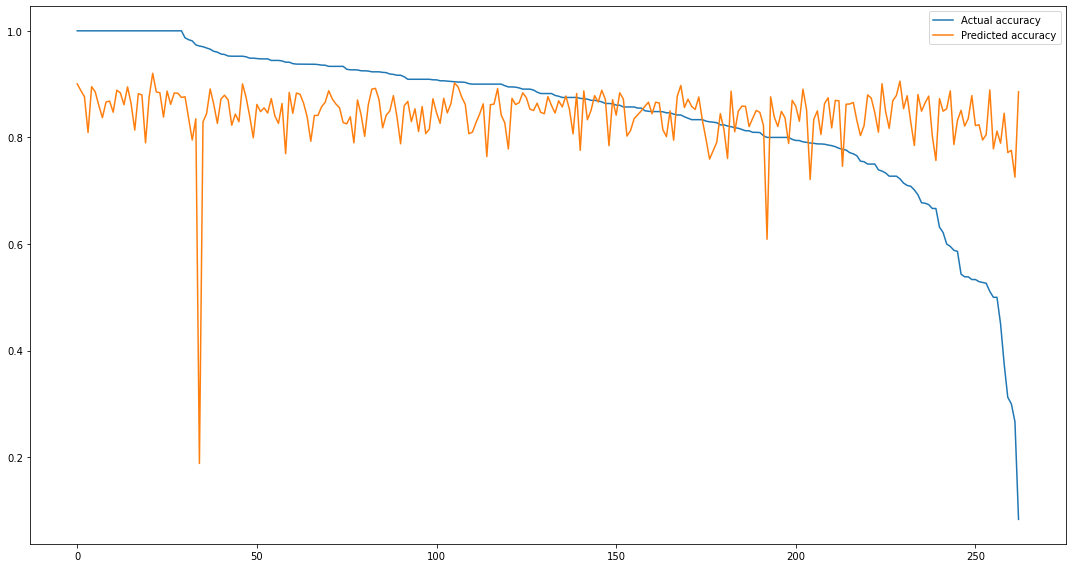

In [14]:
sorted_indices = y_test.argsort()[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(y_test[sorted_indices], label="Actual accuracy")
ax.plot(y_pred[sorted_indices], label="Predicted accuracy")
ax.legend()
fig.tight_layout()

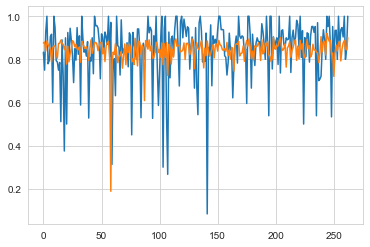

In [47]:
plt.plot(y_test)
plt.plot(y_pred)

# User classification

In [8]:
from sklearn import svm
from sklearn.metrics import accuracy_score

df_users["user_quality_3bins"] = df_users["user_quality_3bins"].astype('category')
df_users["user_quality_3bins_cat"] = df_users["user_quality_3bins"].cat.codes

# X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction',
#               'missing_curb_ramps_with_severity_fraction',
#               'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
#               'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction']]
#X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction']]
y = df_users['user_quality_3bins']

# display(X)
# display(y)

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.39923954372623577

Overall SVM accuracy: 43.26%
              precision    recall  f1-score   support

         Bad       0.52      0.38      0.44       455
        Good       0.42      0.52      0.47       437
     Neutral       0.38      0.40      0.39       421

    accuracy                           0.43      1313
   macro avg       0.44      0.43      0.43      1313
weighted avg       0.44      0.43      0.43      1313



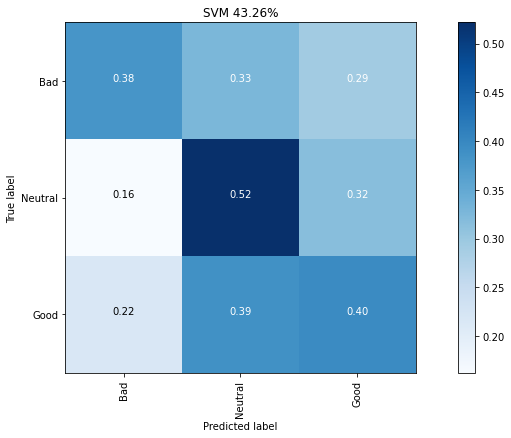

In [9]:
kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='linear', C=1)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
graph_title = f"SVM {accuracy_score(y, y_pred) * 100:.2f}%"
plot_confusion_matrix(cm, classes = ["Bad", "Neutral", "Good"], title=graph_title, normalize=True)
# grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

In [134]:
df_users.groupby('quality_3bins').describe()

validations_received_count                                      \
                                   count        mean         std   min   25%   
quality_3bins                                                                  
Bad                                137.0   76.751825  170.858721  11.0  18.0   
Neutral                            141.0  168.049645  412.948619  11.0  23.0   
Good                               132.0  142.030303  399.523112  11.0  14.0   

                                   accuracy             ...  \
                50%    75%     max    count       mean  ...   
quality_3bins                                           ...   
Bad            30.0   68.0  1519.0    137.0  50.507683  ...   
Neutral        42.0  102.0  2785.0    141.0  73.111286  ...   
Good           23.0   56.5  2921.0    132.0  88.706088  ...   

              surface_problems_with_severity_fraction       \
                                                  75%  max   
quality_3bins                                                
Bad                                               1.0  1.0   
Neutral                                           1.0  1.0   
Good                                              1.0  1.0   

              no_sidewalks_with_severity_fraction                           \
                                            count      mean       std  min   
quality_3bins                                                                
Bad                                         137.0  0.851576  0.247911  0.0   
Neutral                                     141.0  0.911000  0.150522  0.0   
Good                                        132.0  0.921587  0.114386  0.0   

                                             
                    25%       50%  75%  max  
quality_3bins                                
Bad            0.894552  0.894552  1.0  1.0  
Neutral        0.894552  0.911111  1.0  1.0  
Good           0.894552  0.894552  1.0  1.0  

[3 rows x 192 columns]

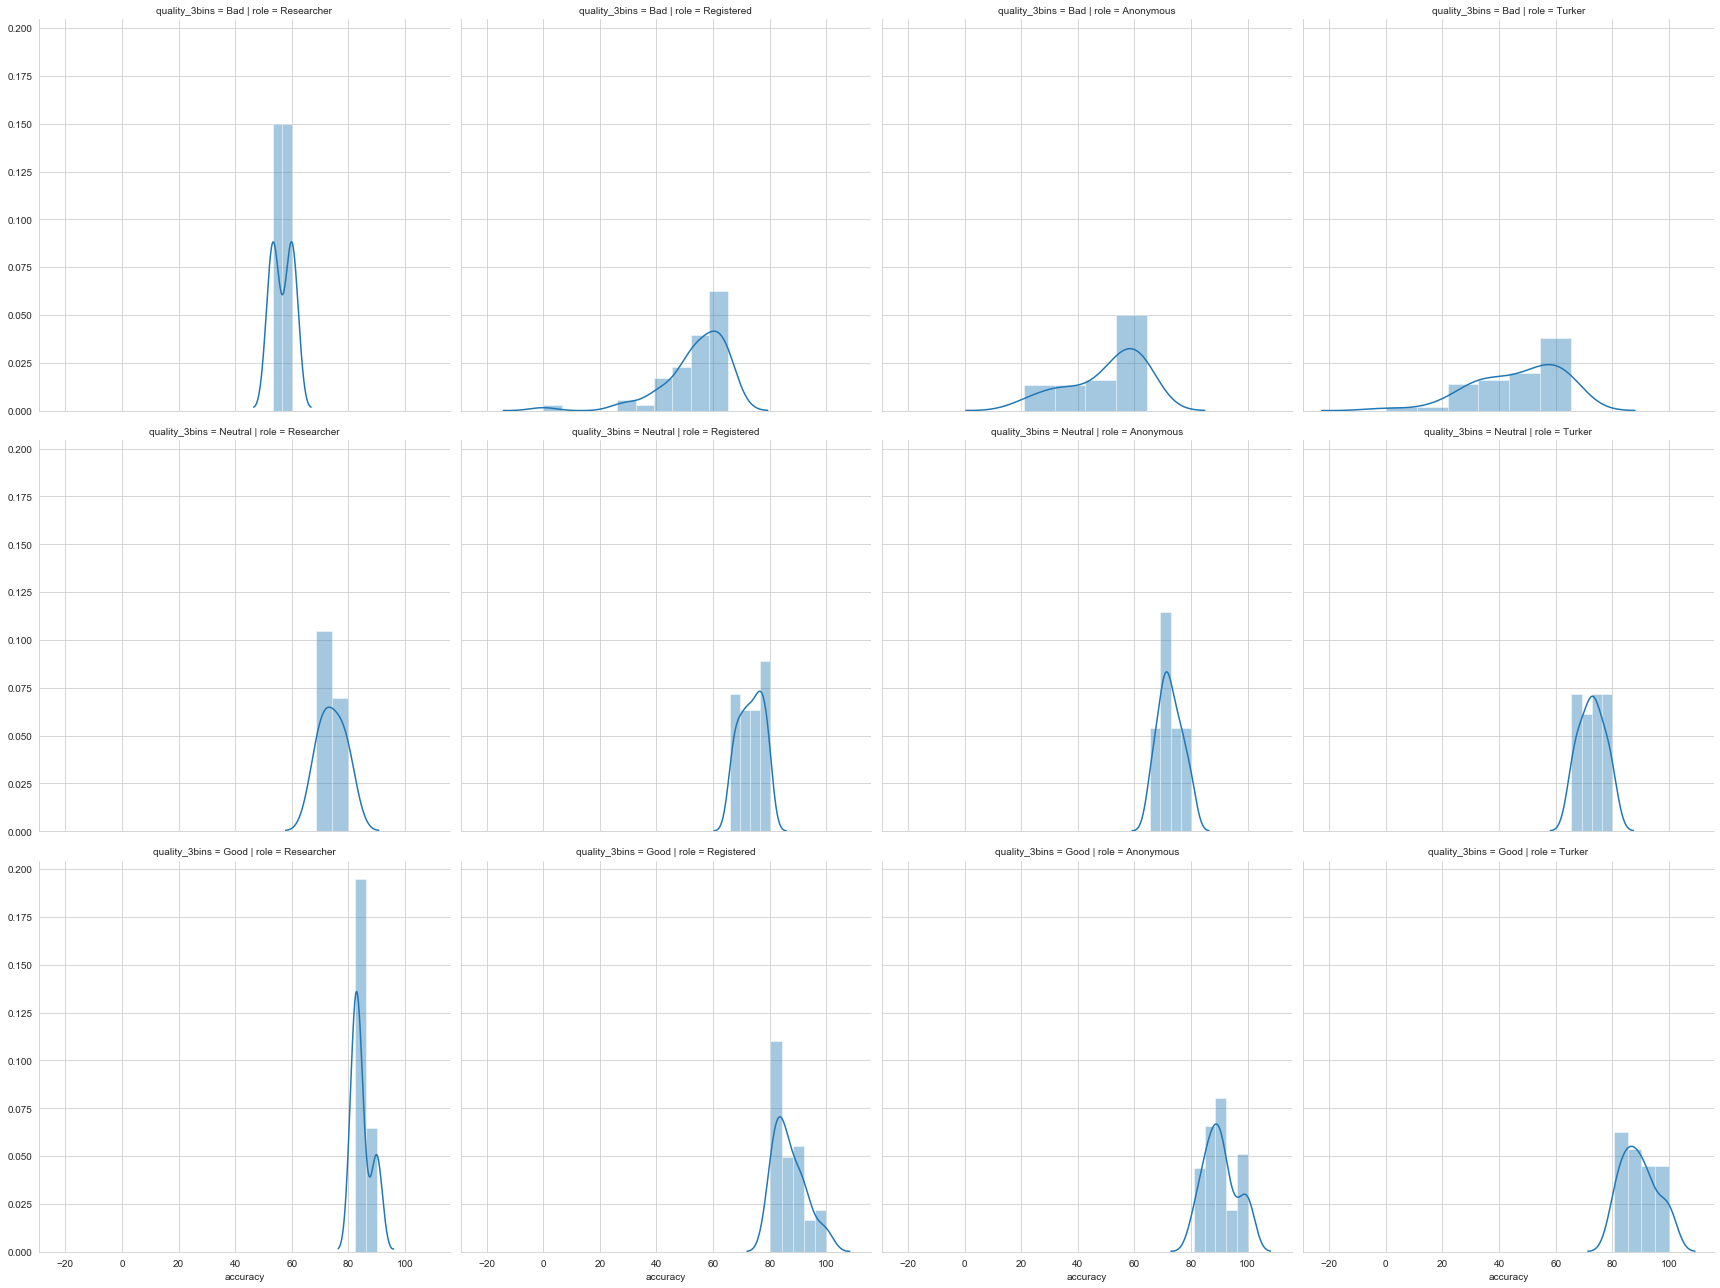

In [133]:
g = sns.FacetGrid(df_users, row='quality_3bins', col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

# Sandbox

## Pairwise correlations

In [51]:
pairwise_corr = df_users.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features")

Text(0.5, 1.0, 'Pairwise correlation of input features')

Error in callback <function flush_figures at 0x00000189BC6E3A60> (for post_execute):


KeyboardInterrupt: 

## Pairplots

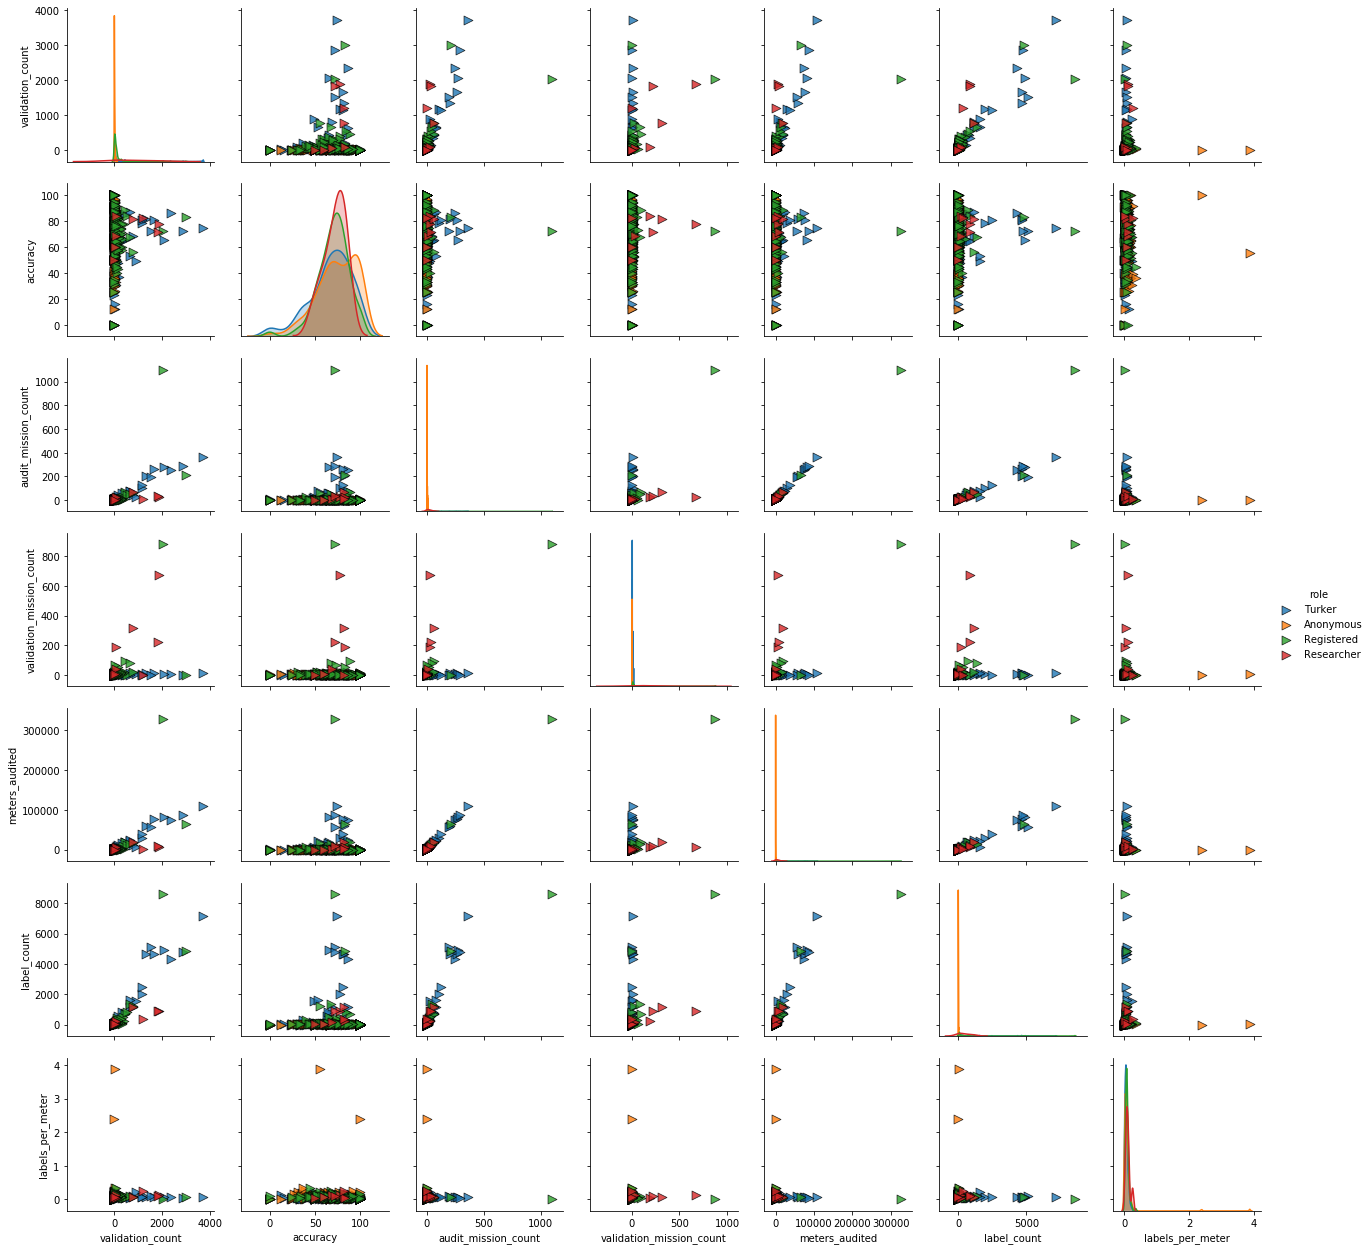

In [122]:
# Create the pairplot (this might take a bit of time)
markers = plot_markers[4]
sns.pairplot(df_users, hue="role", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);